In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, host_subplot
#from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
#import pyPIPS.simulator as sim
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
import pyPIPS.radarmodule as radar
import pyPIPS.polarimetric as dualpol
#from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from scipy import interpolate
from metpy.plots import StationPlot
import metpy.calc as mpcalc
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
from scipy.signal import medfilt2d
import pyart
import cartopy.crs as ccrs
from IPython.display import HTML
from io import StringIO
%matplotlib inline
# %matplotlib notebook
import warnings;
warnings.filterwarnings('ignore')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Function definitions
def readESC(sounding_path, interpnan=True, handle=False):
    """
    Reads in a sounding in ESC format from a provided file path or handle (can be a StringIO object or an open
    file handle)
    """
    col_names = ['pressure','temperature','dewpoint','u_wind','v_wind','speed','direction','height',
                 'Qp_code','Qt_code','Qrh_code','Qu_code','Qv_code']
    # First read the file and extract the field widths from the 14th header line
    if not handle:
        f = open(sounding_path, 'r')
    else:
        f = sounding_path

    # Read in the header and extract some metadata from it
    dummy = f.readline()
    dummy = f.readline()
    header2 = f.readline().strip().split(':')
    # Read next header line and extract station id and wmo number from it (if it exists)
    staid_wmo_str = header2[1]
    if ' / ' in staid_wmo_str:
        staid_wmo = staid_wmo_str.strip().split(' / ')
        staid = staid_wmo[0][1:4]
        wmo = int(staid_wmo[1])
    else:
        if '. ' in staid_wmo_str:
            staid = staid_wmo_str.replace('. ', '').strip()[:4]
        else:
            staid = staid_wmo_str.strip()[:4]
            staid = staid.replace(" ", "")
        wmo = 99999
    print(staid)
    # Read the next header line and extract the location information from it
    header3 = f.readline().strip().split(':')
    location = header3[1].strip().split(',')
    print(location)
    lon = np.float(location[2])
    lat = np.float(location[3])
    elev = np.float(location[4])
    # Read the next header line and extract the time information from it
    header4 = f.readline().strip()[31:].lstrip()   
    sounding_datetime = datetime.strptime(header4, '%Y, %m, %d, %H:%M:%S')
    
    # Now read and dump the rest of the header
    for i in range(9):
        f.readline()
    
    # Except for the last header line, which is used to determine the widths of the fields
    line = f.readline().strip().split()
    fw = [len(field)+1 for field in line]

    # Now read the file into the dataframe, using the extracted field widths
    df = pd.read_fwf(f, usecols=[1, 2, 3, 5, 6, 7, 8, 14, 15, 16, 17, 18, 19],
                     names=col_names, na_values=['99999.0', '9999.0', '999.0'], widths=fw)
    
    # For some reason, need to convert all the columns to floating point here, as some get interpreted as strings
    # when they shouldn't be...
    # print(df['pressure'], df['temperature'])
    for column in df.columns:
        df[column] = df[column].astype(np.float)
    
    # Drop rows where height or pressure is NaN. TODO: Can't remember why I have to use reset_index(drop=True). 
    # Figure this out.
    df = df.dropna(subset=('height', 'pressure')).reset_index(drop=True)
    # Set the height as the index so we can use it as weights to interpolate other columns across NaN
    df = df.set_index('height')
    df['height'] = df.index
    
    if interpnan:
        # First convert direction and speed to u, v components
        df['u'], df['v'] = mpcalc.wind_components(df['speed'].values*units('m/s'),
                                                      df['direction'].values*units.degrees)
        # Now interpolate
        df = df.interpolate(method='values')
        # Finally recompute direction and speed from u, v components
        df['speed'] = mpcalc.wind_speed(df['u'].values*units('m/s'), df['v'].values*units('m/s'))
        df['direction'] = mpcalc.wind_direction(df['u'].values*units('m/s'), df['v'].values*units('m/s'))
    else:
        # Drop any rows with all NaN values for T, Td, winds
        df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed',
                               'u_wind', 'v_wind'), how='all').reset_index(drop=True)
    
    df = df[(df.Qp_code == 1.0) & (df.Qt_code == 1.0) & (df.Qrh_code == 1.0) & (df.Qu_code == 1.0) & 
            (df.Qv_code == 1.0)]

    nlines = df.count()['pressure']
    
    if not handle:
        f.close()
    
    snd_metadata = {
        'sounding_datetime': sounding_datetime,
        'lat': lat,
        'lon': lon,
        'selev': elev,
        'staid': staid,
        'wmo': wmo,
        'nlevs': nlines,
        'staid_long': staid_wmo_str
    }
    
    return snd_metadata, df


def readsharppy(path):
    """Reads in a sounding in sharppy format"""
        ## read in the file
    f = open(path, 'r')
    lines = f.read()
    data = np.array([l.strip() for l in lines.split('\n')])
    f.close()

    ## necessary index points
    title_idx = np.where( data == '%TITLE%')[0][0]
    start_idx = np.where( data == '%RAW%' )[0][0] + 1
    finish_idx = np.where( data == '%END%')[0][0]
    
    ## create the plot title
    data_header = data[title_idx + 1].split()
    location = data_header[0]
    time = data_header[1][:11]

    ## put it all together for StringIO
    full_data = '\n'.join(data[start_idx : finish_idx][:])
    sound_data = StringIO( full_data )

    ## read the data into arrays
    p, h, T, Td, wdir, wspd = np.genfromtxt( sound_data, delimiter=',', comments="%", unpack=True )
    
    col_names = ['pressure','height','temperature','dewpoint','speed','direction']
    data_dict = {key:value for (key,value) in zip(col_names,[p,h,T,Td,wspd,wdir])}
    
    df = pd.DataFrame.from_dict(data_dict)
    
    return df


def roundPartial(value, resolution, decimals=4):
    return np.around(np.round(value / resolution) * resolution, decimals=decimals)


def rain_Brandes(D):
    """Given a range of diameters D, compute rain fall speed curve, a quartic polynomial
       fit after Brandes et al. (2002)."""
    
    D_mm=D*1000. # get it to (mm)
    
    Vtr = -0.1021 + 4.932*D_mm - 0.9551*D_mm**2. + 0.07934*D_mm**3. - 0.002362*D_mm**4.
    
    return Vtr


def cal_xf_tf(usm, vsm, vt, H, perturb_vt=False, sigma=0.1):
    """Computes final horizontal position and residence time (relative to starting position) of a raindrop
       falling through a horizontally homogeneous layer H with terminal velocity vt and 
       storm releative mean wind given by (usm, vsm)."""
    
    if perturb_vt:
        rng = np.random.default_rng()
        vt_perts = sigma * rng.standard_normal(vt.size)
        vt = vt + vt_perts
    
    tf = H / vt
    xf = tf * usm
    yf = tf * vsm
    
    return xf, yf, tf


def mtokm(val,pos):
    """Convert m to km for formatting axes tick labels"""
    val=val/1000.0
    return '%i' % val

def interpolate_all(gridded_radar, tinterp_intv, base_field_name='reflectivity_masked'):
    # Get list of intervals in seconds between subsequent radar times
    tdiffs = gridded_radar['time_seconds'].diff(dim='time')
    
    # This list will hold all the time-interpolated grids (xarray Datasets). 
    # Can later be concatenated into a new xarray Dataset containing all times
    gridded_radar_interp_list = []
    
    # Grab first time from full dataset and restore singular time dimension
    first_time_ds = gridded_radar.isel(time=0)
    first_time_ds = first_time_ds.expand_dims(dim='time')

    gridded_radar_interp_list.append(first_time_ds)
    
#     tbgn = first_time_ds.coords['time_seconds'].values.item()  # Need to get scalar value, not 0-d
#                                                                # numpy array
    
    # Loop through the gridded_radar times, perform advection correction/interpolation between successive times
    # and add each to the list, making sure the time coordinate is consistent
    # new_time = tbgn
    for i, tdiff in enumerate(tdiffs.values):
        gridded_radar_interp_sublist = advection_correction_ds(gridded_radar.isel(time=slice(i, i+2)), 
                                                               tdiff, tinterp_intv, 
                                                               base_field_name=base_field_name)
        for t, gridded_radar_interp in enumerate(gridded_radar_interp_sublist):
#             new_time = new_time + tinterp_intv
#             new_ds = first_time_ds.copy()
#             new_ds[:] = gridded_radar_interp
#             new_ds.coords['time'] = new_ds['time'] + np.timedelta64(int(new_time), 's')
#             new_ds.coords['time_seconds'] = new_time
            gridded_radar_interp_list.append(gridded_radar_interp)
    
    return gridded_radar_interp_list


def advection_correction_ds(radar_ds, tintv_obs, tintv, base_field_name='reflectivity_masked', method="LK"):
    # Evaluate advection
    oflow_method = motion.get_method(method)
    fd_kwargs = {"buffer_mask": 10}  # avoid edge effects

    base_field = radar_ds[base_field_name]
    oflow_field = oflow_method(base_field, fd_kwargs=fd_kwargs)
    
    # Perform temporal interpolation on all variables in Dataset using the flow field derived from the "base"
    # field (by default, reflectivity)
    
    tbgn = base_field[0].coords['time_seconds'].values.item()   # Need to get scalar value, not 0-d
                                                                # numpy array
    
    radar_ds_list = []
    x, y = np.meshgrid(
        np.arange(base_field[0].shape[1], dtype=float), np.arange(base_field[0].shape[0], dtype=float),
    )
    
    new_time = tbgn
    for i in np.arange(tintv, tintv_obs + tintv, tintv):

        new_time = new_time + tintv
        
        pos1 = (y - i / tintv_obs * oflow_field[1], x - i / tintv_obs * oflow_field[0])
        pos2 = (y + (tintv_obs - i) / tintv_obs * oflow_field[1], 
                x + (tintv_obs - i) / tintv_obs * oflow_field[0])
        
        field_interp_list = []
        for field_name, field_da in radar_ds.items():
            fieldt1 = map_coordinates(field_da[0], pos1, order=1)
            fieldt2 = map_coordinates(field_da[1], pos2, order=1)
       
            field_interp = field_da.isel(time=[0]).copy()
            field_interp[:] = ((tintv_obs - i) * fieldt1 + i * fieldt2) / tintv_obs
            field_interp.coords['time'] = field_interp['time'] + np.timedelta64(int(new_time - tbgn), 's')
            field_interp.coords['time_seconds'] = new_time
            field_interp_list.append(field_interp)
        
        radar_ds_interp = xr.merge(field_interp_list)
        radar_ds_list.append(radar_ds_interp)
        
    return radar_ds_list


def advection_correction(arr, tintv_obs, tintv):
    """
    R = np.array([qpe_previous, qpe_current])
    T = time between two observations (5 min)
    t = interpolation timestep (1 min)
    """

    # Evaluate advection
    oflow_method = motion.get_method("LK")
    fd_kwargs = {"buffer_mask": 10}  # avoid edge effects
    V = oflow_method(arr, fd_kwargs=fd_kwargs)

    # Perform temporal interpolation
    # arr_d = np.zeros((arr[0].shape))
    arr_list = []
    x, y = np.meshgrid(
        np.arange(arr[0].shape[1], dtype=float), np.arange(arr[0].shape[0], dtype=float),
    )
    for i in np.arange(tintv, tintv_obs + tintv, tintv):

        pos1 = (y - i / tintv_obs * V[1], x - i / tintv_obs * V[0])
        R1 = map_coordinates(arr[0], pos1, order=1)
        
        pos2 = (y + (tintv_obs - i) / tintv_obs * V[1], x + (tintv_obs - i) / tintv_obs * V[0])
        R2 = map_coordinates(arr[1], pos2, order=1)

        arr_interp = ((tintv_obs - i) * R1 + i * R2) / tintv_obs
        arr_list.append(arr_interp)

    return arr_list

In [3]:
# Read in the gridded radar data
radar_name = 'KHTX'
radar_type= 'NEXRAD'

# For 04/30 case
date = '0430'
radar_start_datetimestamp = '20170430190000'
radar_end_datetimestamp = '20170430235959'
height = 1000.

# For 03/27 case
# date = '0327'
# radar_start_datetimestamp = '20170327190000'
# radar_end_datetimestamp = '20170327220000'
# height = 1000.

# Create datetime objects for start and end times
datetime_start = datetime.strptime(radar_start_datetimestamp, '%Y%m%d%H%M%S')
datetime_end = datetime.strptime(radar_end_datetimestamp, '%Y%m%d%H%M%S')

radar_basedir = \
    '/Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/NEXRAD/PIPS2A_FMCW'
radar_basedir = os.path.join(radar_basedir, '{}/{}'.format(date, radar_name[1:]))
gridded_radar_dir = os.path.join(radar_basedir, 'gridded_new')

radar_start_timestamp = datetime_start.strftime('%Y%m%d%H%M')
radar_end_timestamp = datetime_end.strftime('%Y%m%d%H%M')
gridded_radar_interp_filename = '{}_{}_{}_z{:d}_gridded_interp.nc'.format(radar_name, radar_start_timestamp,
                                                                          radar_end_timestamp, int(height))
gridded_radar_interp_filepath = os.path.join(gridded_radar_dir, gridded_radar_interp_filename)

gridded_radar_interp_ds = xr.open_dataset(gridded_radar_interp_filepath)

In [32]:
plot_dir = '/Users/dawson29/Dropbox/Presentations/AMS2021/plots'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [4]:
# Read in PIPS data
PIPS_data_dir = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/full_PIPS_dataset_RB15/'
PIPS_filename = 'parsivel_combined_FMCW_2017_{}17_PIPS2A_60s.nc'.format(date)
PIPS_filepath = os.path.join(PIPS_data_dir, PIPS_filename)
PIPS_ds = xr.load_dataset(PIPS_filepath)
print(PIPS_ds)

<xarray.Dataset>
Dimensions:                              (diameter_bin: 32, fallspeed_bin: 32, fields_KHTX: 64, parameter: 3, time: 1441)
Coordinates:
  * time                                 (time) datetime64[ns] 2017-04-30T00:...
    fallspeed                            (fallspeed_bin) float64 0.05 ... 20.8
    diameter                             (diameter_bin) float64 0.0625 ... 24.5
    min_diameter                         (diameter_bin) float64 0.0 ... 23.0
    max_diameter                         (diameter_bin) float64 0.125 ... 26.0
    min_fallspeeds                       (fallspeed_bin) float64 0.0 ... 19.2
    max_fallspeeds                       (fallspeed_bin) float64 0.1 ... 22.4
  * parameter                            (parameter) object 'N0' 'lamda' 'alpha'
  * fallspeed_bin                        (fallspeed_bin) float64 0.05 ... 20.8
  * diameter_bin                         (diameter_bin) float64 0.0625 ... 24.5
    flagged_times                        (time) int64 0 

In [5]:
# Grab the location of the PIPS
PIPS_loc = eval(PIPS_ds.location)
PIPS_lat = PIPS_loc[0]
PIPS_lon = PIPS_loc[1]
print(PIPS_loc)
print(PIPS_lat, PIPS_lon)

(34.68711876893391, -86.00486430487216, 200.95575867737972)
34.68711876893391 -86.00486430487216


In [6]:
# Read in sounding file to get low-level wind field and then derive storm-relative wind
# Storm motion taken from subjective reflectivity tag tracking using GRLevel2
# EDIT: don't need storm motion because it is implicitly handled in time-dependent trajectory model
ustorm = 12.51
vstorm = 12.95

# EDIT: setting ustorm, vstorm to 0 to force ground-relative flow
ustorm = 0.
vstorm = 0.

# For 04/30 case
sounding_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/soundings/COMP5mb'
sounding_filename = 'Hollywood_201704301954.cls'

# For 03/27 case
# sounding_dir = '/Users/dawson29/Projects/plotsnd/notebooks/'
# sounding_filename = '201703272100_3469_8600.sharppy'

sounding_path = os.path.join(sounding_dir, sounding_filename)

# For 04/30 case
sounding_metadata, sounding_df = readESC(sounding_path)

# For 03/27 case
# sounding_df = readsharppy(sounding_path)
# wind_dir = sounding_df['direction'].values*units.degrees
# print(wind_dir)
# wind_speed_kts = sounding_df['speed'].values*units.knots 
# wind_speed_ms = wind_speed_kts.to(units('m/s'))
# print(wind_speed_ms)
# u, v = wind_components(wind_speed_ms, wind_dir)
# print(u, v)

Holl
["085 57.41'W", " 34 43.00'N", ' -85.957', ' 34.717', ' 189.0']


<xarray.Dataset>
Dimensions:                           (time: 297)
Coordinates:
  * time                              (time) datetime64[ns] 2017-04-30T19:02:...
    z                                 float64 ...
    y                                 float64 -2.624e+04
    x                                 float64 7.275e+03
    time_seconds                      (time) float64 ...
    lat                               float64 34.69
    lon                               float64 -86.0
Data variables:
    reflectivity_masked               (time) float64 nan nan nan ... 10.69 nan
    differential_reflectivity_masked  (time) float64 nan nan nan ... 0.3913 nan
    D0                                (time) float64 nan nan nan ... 1.332 nan
    Dm                                (time) float64 nan nan nan ... 1.265 nan
    N0                                (time) float64 nan nan ... 2.308e+05 nan
    Nt                                (time) float64 nan nan nan ... 3.96 nan
    RR                   

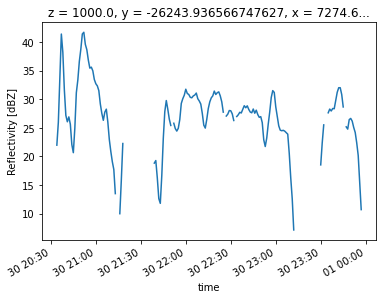

In [7]:
# Find PIPS x, y location by interpolating to its lat/lon point
gridded_radar_interp_latlon_ds = gridded_radar_interp_ds.swap_dims({'x': 'lon', 'y': 'lat'})
radar_at_PIPS_da = gridded_radar_interp_latlon_ds.interp(lat=PIPS_lat, lon=PIPS_lon)
PIPS_x = radar_at_PIPS_da['x'].values.item()
PIPS_y = radar_at_PIPS_da['y'].values.item()
print(radar_at_PIPS_da)
radar_at_PIPS_da['reflectivity_masked'].plot()

In [ ]:
# Plot reflectivity for time-interpolated grid
# Choose a subset of times to keep animation size down
# For 04/30 case

# anim_start = '2017-04-30T19:30'
# anim_end = '2017-04-30T21:00'

# For 03/27 case

anim_start = '2017-03-27T19:30'
anim_end = '2017-03-27T21:00'

var_da = gridded_radar_interp_ds['reflectivity_masked'].sel(time=slice(anim_start, anim_end))
xplt = var_da.coords['x']
yplt = var_da.coords['y']

clevels =np.arange(0., 61., 1.)
norm = cm.colors.Normalize(vmin=0., vmax=60.)

import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(8, 8))

ims = []
for i, var in enumerate(var_da):
    time = var.coords['time_seconds'].values.item()
    ci = ax.contourf(xplt, yplt, var.squeeze(), levels=clevels, 
                     cmap='pyart_HomeyerRainbow', norm=norm)
    # Plot PIPS location
    ax.plot([PIPS_x], [PIPS_y], 'k*')
    if i == 0.:
        fig.colorbar(ci, ax=ax)
        ax.set_aspect('equal')
    ims.append(ci.collections)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
plt.close()
HTML(ani.to_jshtml())
# ani.save('test.mp4')

In [ ]:
var_da = gridded_radar_interp_ds['D0'].sel(time=slice(anim_start, anim_end))

clevels =np.arange(0., 6., 0.1)
norm = cm.colors.Normalize(vmin=0., vmax=6.)

import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(8, 8))

ims = []
for i, var in enumerate(var_da):
    time = var.coords['time_seconds'].values.item()
    ci = ax.contourf(xplt, yplt, var.squeeze(), 
                     levels=clevels, 
                     cmap='pyart_HomeyerRainbow', norm=norm)
    # Plot PIPS location
    ax.plot([PIPS_x], [PIPS_y], 'k*')
    if i == 0.:
        fig.colorbar(ci, ax=ax)
        ax.set_aspect('equal')
    ims.append(ci.collections)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

plt.close()
HTML(ani.to_jshtml())
# plt.show()

In [8]:
# Extract within a small bounding box and for a limited time slice

lat_bgn = 34.3
lat_end = 35.0
lon_bgn = -86.5
lon_end = -85.75

# For 04/30 case
tstart = '2017-04-30T20:00'
tstop = '2017-04-30T21:30'

# For 03/27 case
# tstart = '2017-03-27T19:30'
# tstop = '2017-03-27T21:00'

# ibgn = 50
# iend = 150
# jbgn = 125
# jend = 225
# level = 2
# z_level = gridded_radar.point_z['data'][level, 0, 0]
# z_level = 1000.
gridded_radar_interp_ds = gridded_radar_interp_ds.swap_dims({'y': 'lat', 'x': 'lon'})
gridded_radar_subgrid = gridded_radar_interp_ds.sel(lat=slice(lat_bgn, lat_end), lon=slice(lon_bgn, lon_end),
                                                    time=slice(tstart, tstop))
# gridded_radar_subgrid = gridded_radar_subgrid.squeeze()
gridded_radar_subgrid = gridded_radar_subgrid.transpose('time', 'lat', 'lon')
print(gridded_radar_subgrid)

<xarray.Dataset>
Dimensions:                           (lat: 78, lon: 69, time: 91)
Coordinates:
  * time                              (time) datetime64[ns] 2017-04-30T20:00:...
    z                                 float64 ...
  * lat                               (lat) float64 34.3 34.31 ... 34.99 35.0
  * lon                               (lon) float64 -86.49 -86.48 ... -85.76
    y                                 (lat) float64 -6.9e+04 -6.8e+04 ... 8e+03
    x                                 (lon) float64 -3.8e+04 -3.7e+04 ... 3e+04
    time_seconds                      (time) float64 ...
Data variables:
    reflectivity_masked               (time, lat, lon) float32 ...
    differential_reflectivity_masked  (time, lat, lon) float32 ...
    D0                                (time, lat, lon) float32 ...
    Dm                                (time, lat, lon) float32 ...
    N0                                (time, lat, lon) float32 ...
    Nt                                (time, lat,

In [9]:
# Calculate ND for each grid point from gamma dist. parameters using Parsivel bins
avg_diameters = pp.parsivel_parameters['avg_diameter_bins_mm']
avg_diameters = xr.DataArray(avg_diameters, coords = {'diameter': ('diameter_bin', avg_diameters)}, 
                             dims=['diameter_bin'])

lamda = gridded_radar_subgrid['lamda'] * 1000. # get to m^-1
alpha = gridded_radar_subgrid['mu']
N0 = gridded_radar_subgrid['N0'] * 1000**(1 + alpha) # get to m^-4
ND = dsd.calc_binned_DSD_from_params(N0, lamda, alpha, avg_diameters) * 1.e-3 # Get to m^-3 mm^-1
ND.coords['max_diameter'] = ('diameter_bin', pp.parsivel_parameters['max_diameter_bins_mm'])
ND.coords['min_diameter'] = ('diameter_bin', pp.parsivel_parameters['min_diameter_bins_mm'])

In [10]:
# Set up grid for precip trajectories
# For 04/30 case (FIX THIS to be more general, but we are using ESC format for 04/30, and sharppy for 03/27)
height_AGL_snd = sounding_df['height'] - sounding_metadata['selev']
# For 03/27 case
# height_AGL_snd = sounding_df['height']
# print(gridded_radar_subgrid['x'])
grid_height = gridded_radar_subgrid['z'].values
# grid_height = 2000.
# print(gridded_radar.origin_altitude)
dz = 1.
new_heights = np.arange(0., grid_height + dz, dz)

# Interpolate sounding u, v to new regularly spaced heights
# For 04/30 case (FIXME)
u_snd = sounding_df['u'].values
# For 03/27 case
# u_snd = u
f = interpolate.interp1d(height_AGL_snd, u_snd, bounds_error=False, fill_value=(u_snd[0], u_snd[-1]))
ug = f(new_heights)

# For 04/30 case (FIXME)
v_snd = sounding_df['v'].values
# For 03/27 case
# v_snd = v
f = interpolate.interp1d(height_AGL_snd, v_snd, bounds_error=False, fill_value=(v_snd[0], v_snd[-1]))
vg = f(new_heights)

# Storm-relative winds
usr = ug - ustorm
vsr = vg - vstorm

# Layer-mean storm-relative winds
usm = np.mean(usr)
vsm = np.mean(vsr)
print(usm, vsm)

-2.5473142729992966 9.708396657899332


In [11]:
# Truncate diameter range to less than 9 mm
D_max = 9.
D_range_full = ND['diameter'].values
D_max_ind = np.searchsorted(D_range_full, D_max)
D_range = D_range_full[:D_max_ind]
print(D_range)
ND_trunc = ND.isel(diameter_bin=slice(0, D_max_ind))

# Compute range of terminal velocities from Brandes relation
vt_range = rain_Brandes(D_range / 1000.)
print(vt_range)

# Set dimensions back from lat/lon to y/x for ND_trunc
ND_trunc = ND_trunc.swap_dims({'lon': 'x', 'lat': 'y'})
ND_trunc = ND_trunc.swap_dims({'time': 'time_seconds'})

# Interpolate ND to a finer grid
# Set up grid of locations
x_coords = ND_trunc['x']
y_coords = ND_trunc['y']
t_coords = ND_trunc['time_seconds']

refinement_factor = 5
time_refinement_factor = 1

new_x_coords = np.linspace(x_coords.x[0], x_coords.x[-1], (x_coords.sizes['x'] - 1) * refinement_factor + 1)
new_y_coords = np.linspace(y_coords.y[0], y_coords.y[-1], (y_coords.sizes['y'] - 1) * refinement_factor + 1)
new_t_coords = np.linspace(t_coords.time_seconds[0], t_coords.time_seconds[-1], 
                           (t_coords.sizes['time_seconds'] - 1) * time_refinement_factor + 1)

print(new_t_coords)

ND_trunc = ND_trunc.interp(x=new_x_coords, y=new_y_coords, time_seconds=new_t_coords)

x_grid, y_grid, t_grid = xr.broadcast(ND_trunc['x'], ND_trunc['y'], ND_trunc['time_seconds'])

x_flat = x_grid.stack(loc=['time_seconds', 'y', 'x']).values
y_flat = y_grid.stack(loc=['time_seconds', 'y', 'x']).values
t_flat = t_grid.stack(loc=['time_seconds', 'y', 'x']).values

# Compute horizontal deviations of drops and residence time at bottom of layer for each grid point and drop size
# TODO: Generalize this for spatially varying velocity field. Would require a numerical trajectory integration
# TODO: Update this to perturb the terminal velocities for all grid points (already modified the function above)
xf, yf, tf = cal_xf_tf(usm, vsm, vt_range, grid_height)
x_flat_f = x_flat[:, np.newaxis] + xf
y_flat_f = y_flat[:, np.newaxis] + yf

# Create array of times corresponding to each initial time for trajectory endpoints as a function of diameter
t_flat_f = t_flat[:, np.newaxis] + tf

x_flat_f = x_flat_f.T
y_flat_f = y_flat_f.T
t_flat_f = t_flat_f.T

# Perturb the endpoints a bit in space and time
xpertscale = 20. # m
tpertscale = 1. # s
rng = np.random.default_rng()
xpert = xpertscale * rng.standard_normal(size=x_flat_f.shape)
ypert = xpertscale * rng.standard_normal(size=y_flat_f.shape)
tpert = tpertscale * rng.standard_normal(size=t_flat_f.shape)

xpert = np.where(xpert < -10.*xpertscale, 0., xpert)
xpert = np.where(xpert > 10.*xpertscale, 0., xpert)
ypert = np.where(ypert < -10.*xpertscale, 0., ypert)
ypert = np.where(ypert > 10.*xpertscale, 0., ypert)
tpert = np.where(tpert < -10.*tpertscale, 0., tpert)
tpert = np.where(tpert > 10.*tpertscale, 0., tpert)

# x_flat_f = x_flat_f + xpert
# y_flat_f = y_flat_f + ypert
# t_flat_f = t_flat_f + tpert

ND_trunc = ND_trunc.transpose('diameter_bin', 'time_seconds', 'y', 'x')
print(x_flat_f.shape, y_flat_f.shape, t_flat_f.shape)

[0.0625 0.1875 0.3125 0.4375 0.5625 0.6875 0.8125 0.9375 1.0625 1.1875
 1.375  1.625  1.875  2.125  2.375  2.75   3.25   3.75   4.25   4.75
 5.5    6.5    7.5    8.5   ]
[0.20243847 0.78959234 1.34827725 1.87939531 2.38383474 2.86246996
 3.31616154 3.7457562  4.15208682 4.53597247 5.07147419 5.71431825
 6.28142631 6.77868642 7.2117652  7.75289421 8.29872984 8.67865684
 8.92737921 9.07605796 9.17093988 9.17535487 9.16157188 9.20881488]
[3480. 3540. 3600. 3660. 3720. 3780. 3840. 3900. 3960. 4020. 4080. 4140.
 4200. 4260. 4320. 4380. 4440. 4500. 4560. 4620. 4680. 4740. 4800. 4860.
 4920. 4980. 5040. 5100. 5160. 5220. 5280. 5340. 5400. 5460. 5520. 5580.
 5640. 5700. 5760. 5820. 5880. 5940. 6000. 6060. 6120. 6180. 6240. 6300.
 6360. 6420. 6480. 6540. 6600. 6660. 6720. 6780. 6840. 6900. 6960. 7020.
 7080. 7140. 7200. 7260. 7320. 7380. 7440. 7500. 7560. 7620. 7680. 7740.
 7800. 7860. 7920. 7980. 8040. 8100. 8160. 8220. 8280. 8340. 8400. 8460.
 8520. 8580. 8640. 8700. 8760. 8820. 8880.]
(24, 1

(5382, 24)
<xarray.DataArray (y: 78, x: 69)>
array([[2883.94337977, 1903.01157643, 1316.56227614, ...,    0.        ,
           0.        ,    0.        ],
       [2508.65778868, 1844.5216536 , 1418.17887792, ...,    0.        ,
           0.        ,    0.        ],
       [2431.55312503, 1887.48601119, 1465.15562668, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [ 419.93729244,   66.41372648,  107.27154549, ...,    0.        ,
           0.        ,    0.        ],
       [ 368.77239759,   49.6780513 ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [ 264.96253447,   52.92395254,    0.        , ...,    0.        ,
           0.        ,    0.        ]])
Coordinates:
    z             float64 1e+03
    lat           (y) float64 34.3 34.31 34.32 34.33 ... 34.97 34.98 34.99 35.0
    lon           (x) float64 -86.49 -86.48 -86.47 ... -85.78 -85.77 -85.76
  * x             (x) float64 -3.8e+04 -3.7e+04 -3.6e+04 ... 2.9e+04 

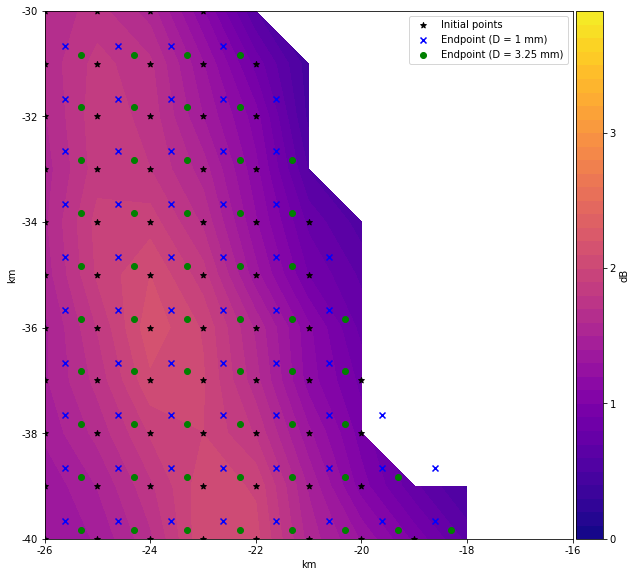

In [40]:
# Test plot of endpoints

x_grid_plt = x_grid.sel(time_seconds=3600.)
y_grid_plt = y_grid.sel(time_seconds=3600.)

x_grid_plt = x_grid_plt.thin(indexers=5)
y_grid_plt = y_grid_plt.thin(indexers=5)

x_flat_plt = x_grid_plt.stack(loc=['y', 'x']).values
y_flat_plt = y_grid_plt.stack(loc=['y', 'x']).values

# Compute horizontal deviations of drops and residence time at bottom of layer for each grid point and drop size
# TODO: Generalize this for spatially varying velocity field. Would require a numerical trajectory integration
# TODO: Update this to perturb the terminal velocities for all grid points (already modified the function above)
x_flat_f_plt = x_flat_plt[:, np.newaxis] + xf
y_flat_f_plt = y_flat_plt[:, np.newaxis] + yf

print(x_flat_f_plt.shape)

Nt = ND_trunc.sel(time_seconds=3600.).sum(dim='diameter_bin')
Nt = Nt.thin(indexers=5)
print(Nt)
Nt_flat = Nt.values.flatten()
indices = np.where(Nt_flat > 0.)[0]
# indices = indices[::100]

print(ND_trunc['diameter'].values)

x_flat_f_0 = x_flat_f_plt[:, 8]
y_flat_f_0 = y_flat_f_plt[:, 8]
x_flat_f_1 = x_flat_f_plt[:, 16]
y_flat_f_1 = y_flat_f_plt[:, 16]

gridded_radar_subgrid_2 = gridded_radar_subgrid.swap_dims({'time': 'time_seconds'})

var_da = gridded_radar_subgrid_2['differential_reflectivity_masked'].sel(time_seconds=3600.)
xplt = gridded_radar_subgrid_2.coords["x"]
yplt = gridded_radar_subgrid_2.coords["y"]
# print(xplt[0], xplt[-1], yplt[0], yplt[-1])

clevels =np.arange(0., 4., 0.1)
norm = cm.colors.Normalize(vmin=0., vmax=4.)
fig, ax = plt.subplots(figsize=(10,10))
ci = ax.contourf(xplt, yplt, var_da.squeeze(), levels=clevels, cmap='plasma', norm=norm)
ax.scatter(x_flat_plt[indices], y_flat_plt[indices], marker='*', color='k', label='Initial points')
ax.scatter(x_flat_f_0[indices], y_flat_f_0[indices], marker='x', color='b', label='Endpoint (D = 1 mm)')
ax.scatter(x_flat_f_1[indices], y_flat_f_1[indices], marker='o', color='g', label='Endpoint (D = 3.25 mm)')

cbarintv = 1.
cbarlevels = ticker.MultipleLocator(base=cbarintv)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ci, orientation='vertical', ticks=cbarlevels, cax=cax)
cax.set_ylabel('dB')



ax.set_xlim(-26000., -16000.)
ax.set_ylim(-40000., -30000.)
formatter = ticker.FuncFormatter(mtokm)
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.legend()
ax.set_aspect('equal')

plot_filename = 'trajectory_endpoint_example.png'
plot_filepath = os.path.join(plot_dir, plot_filename)
fig.savefig(plot_filepath, dpi=300, bbox_inches='tight')

In [39]:
print(gridded_radar_subgrid['time_seconds'])
print(gridded_radar_subgrid['time'])

<xarray.DataArray 'time_seconds' (time: 91)>
array([3480., 3540., 3600., 3660., 3720., 3780., 3840., 3900., 3960., 4020.,
       4080., 4140., 4200., 4260., 4320., 4380., 4440., 4500., 4560., 4620.,
       4680., 4740., 4800., 4860., 4920., 4980., 5040., 5100., 5160., 5220.,
       5280., 5340., 5400., 5460., 5520., 5580., 5640., 5700., 5760., 5820.,
       5880., 5940., 6000., 6060., 6120., 6180., 6240., 6300., 6360., 6420.,
       6480., 6540., 6600., 6660., 6720., 6780., 6840., 6900., 6960., 7020.,
       7080., 7140., 7200., 7260., 7320., 7380., 7440., 7500., 7560., 7620.,
       7680., 7740., 7800., 7860., 7920., 7980., 8040., 8100., 8160., 8220.,
       8280., 8340., 8400., 8460., 8520., 8580., 8640., 8700., 8760., 8820.,
       8880.])
Coordinates:
  * time          (time) datetime64[ns] 2017-04-30T20:00:00 ... 2017-04-30T21...
    z             float64 1e+03
    time_seconds  (time) float64 3.48e+03 3.54e+03 3.6e+03 ... 8.82e+03 8.88e+03
<xarray.DataArray 'time' (time: 91)>
arr

In [ ]:
# Set up 3D bins (2 for space, 1 for time) for bottom of sorting layer

dx_bins = 500.
dx_orig = new_x_coords[1] - new_x_coords[0]
print("dx (top), dx (bottom)", dx_orig, dx_bins)
area_ratio = dx_bins**2. / dx_orig**2.
print("area ratio: ", area_ratio)
# Get bounding box of bottom of domain
# xmin = int(x_flat_f.min()) # -5000.
# xmax = int(x_flat_f.max())
# ymin = int(y_flat_f.min()) # -5000.
# ymax = int(y_flat_f.max())

# Or, just use the original bounds
xmin = new_x_coords[0]
xmax = new_x_coords[-1]
ymin = new_y_coords[0]
ymax = new_y_coords[-1]

# Create bins for bottom of domain
xbins = int((xmax-xmin)/dx_bins)
ybins = int((ymax-ymin)/dx_bins)

print(xbins)
print(ybins)
xmax = xmin+dx_bins*xbins # +5000.
ymax = ymin+dx_bins*ybins # +5000.
print(xmin, xmax, ymin, ymax)

# Set up time bins
# EDIT: just use original time bins
tintv = 60.
# tmin = t_flat_f.min()
# tmax = t_flat_f.max()
# print(tmin, tmax)
# tbins = int((tmax - tmin) / tintv)
tmin = ND_trunc['time_seconds'][0].values
tmax = ND_trunc['time_seconds'][-1].values + tintv
tbins = int((tmax - tmin) / tintv)
print(tmin, tmax, tbins)



In [ ]:
# Create 3D histogram (x, y, t) for number density for each diameter bin for drop trajectory endpoints

ND_D_binned_list = []

for i, ND_D in enumerate(ND_trunc):
    print("Index: ", i)
    x = x_flat_f[i]
    y = y_flat_f[i]
    t = t_flat_f[i]
    
    coords = np.stack([x, y, t], axis=1)
    ND_D_binned, edges = np.histogramdd(coords,
                                        bins=[xbins, ybins, tbins],
                                        range=[[xmin, xmax], [ymin, ymax], [tmin, tmax]],
                                        weights=ND_D.values.flatten())
    ND_D_binned_list.append(ND_D_binned)

    
ND_D_binned = np.array(ND_D_binned_list)
xedges, yedges, tedges = edges
# Shift times to start at 0 again
tedges = tedges - tedges[0]
start_time = ND['time'][0].values
attrs = {"units": "seconds since {}".format(start_time)}

ND_f_da = xr.DataArray(ND_D_binned,
                       coords={
                           "diameter": ND_trunc['diameter'], 
                           "x": xedges[:-1],
                           "y": yedges[:-1],
                           "time_seconds": tedges[:-1],
                       },
                       dims=["diameter_bin", "x", "y", "time_seconds"])

ND_f_da.coords["time"] = ("time_seconds", ND_f_da["time_seconds"], attrs)
ND_f_ds = xr.decode_cf(ND_f_da.to_dataset(name='ND'))
ND_f_ds = ND_f_ds.swap_dims({"time_seconds": "time"})
ND_f_ds.coords['max_diameter'] = ('diameter_bin', pp.parsivel_parameters['max_diameter_bins_mm'][:D_max_ind])
ND_f_ds.coords['min_diameter'] = ('diameter_bin', pp.parsivel_parameters['min_diameter_bins_mm'][:D_max_ind])
ND_f_ds = ND_f_ds.transpose("time", "y", "x", "diameter_bin")
ND_f_ds = ND_f_ds.swap_dims({'diameter_bin': 'diameter'}) # Do this so we can use it for sel function. May
                                                          # break other stuff so make sure to check later.

In [ ]:
# Plot ND animation for a given diameter bin
D_to_plot = 1.

xctr = 0.5 * (xedges[1:] + xedges[:-1])
yctr = 0.5 * (yedges[1:] + yedges[:-1])

var_da = ND_f_ds['ND'].sel(diameter=D_to_plot, method='nearest')
var_da = var_da.sel(time=slice(anim_start, anim_end))

# print(xplt[0], xplt[-1], yplt[0], yplt[-1])

clevels = np.logspace(-1., 4., num=100)
norm = cm.colors.LogNorm(vmin=1., vmax=10000.)
fig, ax = plt.subplots(figsize=(10, 10))

ims = []
for i, var in enumerate(var_da):
    time = var.coords['time_seconds'].values
    ci = ax.contourf(xctr, yctr, var.squeeze(), 
                     levels=clevels, 
                     cmap='plasma', norm=norm)
    ax.plot([PIPS_x], [PIPS_y], 'k*')
    if i == 0.:
        fig.colorbar(ci, ax=ax)
        # ax.set_xlim(xplt[0], xplt[-1])
        # ax.set_ylim(yplt[0], yplt[-1])
        ax.set_aspect('equal')
    ims.append(ci.collections)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

plt.close()
HTML(ani.to_jshtml())

In [ ]:
# Calculate radar variables for new surface DSDs
# Get polarimetric variables
# This uses a *ton* of memory. Need to think of ways to lower the memory footprint
# ND_f_ds = ND_f_ds.swap_dims({'diameter': 'diameter_bin'})
dD = ND_f_ds['max_diameter'] - ND_f_ds['min_diameter']
dualpol_dict = dualpol.calpolrain_bulk_xr(10.7, 
                                          '/Users/dawson29/Projects/pyPIPS/tmatrix/S-Band/SCTT_RAIN_fw100.dat',
                                          ND_f_ds['ND'], dD, diameter_bin_name='diameter')
print(dualpol_dict.keys())

In [ ]:
# Plot reflectivity at bottom of sorting layer

xctr = 0.5 * (xedges[1:] + xedges[:-1])
yctr = 0.5 * (yedges[1:] + yedges[:-1])

var_da = dualpol_dict['REF']
# var_da = var_da.sel(time=slice(anim_start, anim_end))
# print(xplt[0], xplt[-1], yplt[0], yplt[-1])

clevels =np.arange(0., 61., 1.)
norm = cm.colors.Normalize(vmin=0., vmax=60.)

import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(10, 10))

ims = []
for i, var in enumerate(var_da):
    time = var.coords['time_seconds'].values.item()
    ci = ax.contourf(xctr, yctr, var.squeeze(), 
                     levels=clevels, 
                     cmap='pyart_HomeyerRainbow', norm=norm)
    ax.plot([PIPS_x], [PIPS_y], 'k*')
    if i == 0.:
        fig.colorbar(ci, ax=ax)
        # ax.set_xlim(xplt[0], xplt[-1])
        # ax.set_ylim(yplt[0], yplt[-1])
        ax.set_aspect('equal')
    ims.append(ci.collections)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
plt.close()
HTML(ani.to_jshtml())
# plt.show()

In [ ]:

# xctr = 0.5 * (xedges[1:] + xedges[:-1])
# yctr = 0.5 * (yedges[1:] + yedges[:-1])

var_da = gridded_radar_subgrid['reflectivity_masked']
xplt = gridded_radar_subgrid.coords["x"]
yplt = gridded_radar_subgrid.coords["y"]
# print(xplt[0], xplt[-1], yplt[0], yplt[-1])

clevels =np.arange(0., 61., 1.)
norm = cm.colors.Normalize(vmin=0., vmax=60.)

import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(10, 10))

ims = []
for i, var in enumerate(var_da):
    time = var.coords['time_seconds'].values.item()
    ci = ax.contourf(xplt, yplt, var.squeeze(), 
                     levels=clevels, 
                     cmap='pyart_HomeyerRainbow', norm=norm)
    if i == 0.:
        fig.colorbar(ci, ax=ax)
        # ax.set_xlim(xplt[0], xplt[-1])
        # ax.set_ylim(yplt[0], yplt[-1])
        ax.set_aspect('equal')
    ims.append(ci.collections)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

HTML(ani.to_jshtml())
# plt.show()

In [ ]:
# Plot ZDR at bottom of sorting layer

# xctr = 0.5 * (xedges[1:] + xedges[:-1])
# yctr = 0.5 * (yedges[1:] + yedges[:-1])

var_da = dualpol_dict['ZDR']
# print(xplt[0], xplt[-1], yplt[0], yplt[-1])

clevels =np.arange(0., 6., 0.1)
norm = cm.colors.Normalize(vmin=0., vmax=6.)

import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(10, 10))

ims = []
for i, var in enumerate(var_da):
    time = var.coords['time_seconds'].values.item()
    ci = ax.contourf(xctr, yctr, var.squeeze(), 
                     levels=clevels, 
                     cmap='pyart_HomeyerRainbow', norm=norm)
    ax.plot([PIPS_x], [PIPS_y], 'k*')
    if i == 0.:
        fig.colorbar(ci, ax=ax)
        # ax.set_xlim(xplt[0], xplt[-1])
        # ax.set_ylim(yplt[0], yplt[-1])
        ax.set_aspect('equal')
    ims.append(ci.collections)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

HTML(ani.to_jshtml())
# plt.show()

In [ ]:
from IPython.display import HTML

# xctr = 0.5 * (xedges[1:] + xedges[:-1])
# yctr = 0.5 * (yedges[1:] + yedges[:-1])

var_da = gridded_radar_subgrid['differential_reflectivity_masked']
xplt = gridded_radar_subgrid.coords["x"]
yplt = gridded_radar_subgrid.coords["y"]
# print(xplt[0], xplt[-1], yplt[0], yplt[-1])

clevels =np.arange(0., 6., 0.1)
norm = cm.colors.Normalize(vmin=0., vmax=6.)

import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(10, 10))

ims = []
for i, var in enumerate(var_da):
    time = var.coords['time_seconds'].values.item()
    ci = ax.contourf(xplt, yplt, var.squeeze(), 
                     levels=clevels, 
                     cmap='pyart_HomeyerRainbow', norm=norm)
    if i == 0.:
        fig.colorbar(ci, ax=ax)
        # ax.set_xlim(xplt[0], xplt[-1])
        # ax.set_ylim(yplt[0], yplt[-1])
        ax.set_aspect('equal')
    ims.append(ci.collections)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

HTML(ani.to_jshtml())
# plt.show()

In [ ]:
ZH_interp_PIPS_da = dualpol_dict['REF'].interp(x=PIPS_x, y=PIPS_y)
print(ZH_interp_PIPS_da)

In [ ]:
ZH_PIPS = dualpol_dict_PIPS['REF']
ZH_PIPS.plot(xlim=(anim_start, anim_end), color='k')
ZH_interp_PIPS_da.plot(xlim=(anim_start, anim_end), color='b')
radar_at_PIPS_da['reflectivity_masked'].plot(xlim=(anim_start, anim_end),
                                                   color='g')
PIPS_ds['KHTX_at_PIPS'].sel(fields_KHTX='REF').plot(xlim=(anim_start, anim_end),
                                                             color='purple')

In [ ]:
print(PIPS_ds)

In [ ]:
ZDR_interp_PIPS_da = dualpol_dict['ZDR'].interp(x=PIPS_x, y=PIPS_y)

In [ ]:
dD = PIPS_ds['max_diameter'] - PIPS_ds['min_diameter']
dualpol_dict_PIPS = dualpol.calpolrain_bulk_xr(10.7, 
                                               '/Users/dawson29/Projects/pyPIPS/tmatrix/S-Band/SCTT_RAIN_fw100.dat',
                                               PIPS_ds['ND_qc'], dD, diameter_bin_name='diameter_bin')

In [ ]:
ZDR_PIPS = dualpol_dict_PIPS['ZDR']
ZDR_PIPS.plot(xlim=(anim_start, anim_end), color='k')
ZDR_interp_PIPS_da.plot(xlim=(anim_start, anim_end), color='b')
radar_at_PIPS_da['differential_reflectivity_masked'].plot(xlim=(anim_start, anim_end),
                                                          color='g')
PIPS_ds['KHTX_at_PIPS'].sel(fields_KHTX='ZDR_filtered').plot(xlim=(anim_start, anim_end),
                                                             color='purple')

In [ ]:
# Combine sorted ND and polarimetric arrays together into a single dataset and dump to disk
print(ND_f_ds)

In [ ]:
print(dualpol_dict['REF'])

In [ ]:
sorted_ds = ND_f_ds.copy()
sorted_ds['REF'] = dualpol_dict['REF']
sorted_ds['ZDR'] = dualpol_dict['ZDR']
print(sorted_ds)

In [ ]:
# Dump to file 

# Add some metadata first
sorted_ds.attrs['orig_dx'] = dx_orig * refinement_factor
sorted_ds.attrs['top_dx'] = dx_orig
sorted_ds.attrs['bottom_dx'] = dx_bins
sorted_ds.attrs['sorting_layer_top'] = height
sorted_ds.attrs['sorting_layer_bottom'] = 0.  # Generalize this later

# print(sorted_ds)

tstart_datetime = datetime.strptime(tstart, '%Y-%m-%dT%H:%M')
tstop_datetime = datetime.strptime(tstop, '%Y-%m-%dT%H:%M')

tstart_out = tstart_datetime.strftime('%Y%m%d%H%M')
tstop_out = tstop_datetime.strftime('%Y%m%d%H%M')

sorted_filename = '{}_{}_{}_d{:d}_gridded_sorted.nc'.format(radar_name, tstart_out, tstop_out, int(height))
print(sorted_filename)
sorted_path = os.path.join(gridded_radar_dir, sorted_filename)
print(sorted_path)
sorted_ds.to_netcdf(sorted_path)